In [18]:
import os
os.chdir("/Users/karol/Desktop/Antwerp/ai_project")
import torch
import torch.nn as nn
from model import TwoTowerCustomer, TwoTowerFinal
from data_reader import load_data_mf, load_customers_articles, matrix_representation
from helper import train_two_tower
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from recommenders import recommender_two_towers_customer, recommender_two_towers_final
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from scipy.sparse import csr_array
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score

In [2]:
# read customers and transactions data
customers = pd.read_csv("data/preprocessed/customers.csv") 
transactions = pd.read_csv("data/preprocessed/transactions.csv") 
articles = pd.read_csv("data/preprocessed/articles.csv") 


# Sales channel preference

In [3]:
def sales_channel_preference(customers, transactions):
    grouped = transactions.groupby(["customer_id", "sales_channel_id"])["article_id"].count()
    percentages = grouped / grouped.groupby(level=0).transform("sum")
    # create first_cahnnel feature
    first_sales_channel = percentages[percentages.index.get_level_values('sales_channel_id') == 1]
    first_sales_channel = first_sales_channel.rename("first_channel")
    customers = customers.merge(first_sales_channel, how="left", on="customer_id")
    customers["first_channel"] = customers["first_channel"].fillna(0)
    # create second_cahnnel feature
    second_sales_channel = percentages[percentages.index.get_level_values('sales_channel_id') == 2]
    second_sales_channel = second_sales_channel.rename("second_channel")
    customers = customers.merge(second_sales_channel, how="left", on="customer_id")
    customers["second_channel"] = customers["second_channel"].fillna(0)
    return customers

# Favourite colour - Determine favourite color depending on the season.


In [4]:
def favourite_colour(customers, articles, transactions, quarter=4):
    # get specific quarter we are interested in
    transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
    transactions["quarter"] = transactions["t_dat"].dt.quarter  
    transactions = transactions[transactions["quarter"]==quarter]
    # merge colour information
    transactions = transactions.merge(articles[["article_id","perceived_colour_master_name"]], how="left", on="article_id")
    # get favourite colors
    grouped = transactions.groupby(["customer_id","perceived_colour_master_name"])["article_id"].count()
    max_indices = grouped.groupby(level=0).idxmax()
    favourite_color = grouped.loc[max_indices]
    favourite_color = favourite_color.rename("favourite_color")
    customers = customers.merge(favourite_color, how="left", on="customer_id")
    # Fill NAs with -1 indicating customer didn't buy anythin
    customers["favourite_color"] = customers["favourite_color"].fillna(-1)
    return customers
    

# Favourite garment group - preferred if over 50% otherwise mixed

In [5]:
def preferred_garment(customers, articles, transactions):
    transactions = transactions.merge(articles[["article_id","garment_group_name"]], how="left", on="article_id")
    grouped = transactions.groupby(["customer_id", "garment_group_name"])["article_id"].count()
    percentages = grouped / grouped.groupby(level=0).transform("sum")
    preferred_garment = percentages[percentages > 0.5]
    df_garment = pd.DataFrame(preferred_garment).reset_index()[["customer_id","garment_group_name"]]
    df_garment.rename(columns={"garment_group_name":"preferred_garment"}, inplace=True)
    customers = customers.merge(df_garment, how="left", on="customer_id")
    customers["preferred_garment"] = customers["preferred_garment"].fillna(-1)
    return customers

# Average price

In [6]:
def avg_price(customers, transactions):
    avg_grouped = transactions.groupby("customer_id")["price"].mean()
    avg_grouped = avg_grouped.rename("avg_price")
    customers = customers.merge(avg_grouped, how="left", on="customer_id")
    customers["avg_price"] = customers["avg_price"].fillna(0)
    return customers

# Amount of recent purchases

In [7]:
def amount_purchases(customers, transactions, date_thrashold="2020-08-22"):
    # select recent transactions
    transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
    transactions = transactions[transactions["t_dat"]>date_thrashold]
    # get counts
    grouped = transactions.groupby("customer_id")["article_id"].count()
    grouped = grouped.rename("amount_purchases")
    customers = customers.merge(grouped, how="left", on="customer_id")
    customers["amount_purchases"] = customers["amount_purchases"].fillna(0)
    return customers

# Man, Lady & Kids detection

In [8]:
def sex_kid_estimation(customers, articles, transactions):
    transactions = transactions.merge(articles[["article_id", "index_name"]], how="left", on="article_id")
    grouped = transactions.groupby(["customer_id", "index_name"])["article_id"].count()
    percentages = grouped/grouped.groupby(level=0).transform("sum")
    # get menswear 
    manswear = percentages[percentages.index.get_level_values('index_name') == 3]
    manswear = manswear.rename("manswear")
    customers = customers.merge(manswear, how="left", on="customer_id")
    customers["manswear"] = customers["manswear"].fillna(0)
    # get ledieswear
    ladieswear = percentages[percentages.index.get_level_values('index_name').isin([0,1,4])].groupby("customer_id").sum()
    ladieswear = ladieswear.rename("ladieswear")
    customers = customers.merge(ladieswear, how="left", on="customer_id")
    customers["ladieswear"] = customers["ladieswear"].fillna(0)
    # get kids 
    kids = percentages[percentages.index.get_level_values('index_name').isin([2,6,8,9])].groupby("customer_id").sum()
    kids = kids.rename("kids")
    customers = customers.merge(kids, how="left", on="customer_id")
    customers["kids"] = customers["kids"].fillna(0)
    return customers

# Generate Features

In [9]:
customers = sales_channel_preference(customers, transactions)
customers = favourite_colour(customers, articles, transactions, quarter=4)
customers = preferred_garment(customers, articles, transactions)
customers = avg_price(customers, transactions)
customers = amount_purchases(customers, transactions, date_thrashold="2020-08-22")
customers = sex_kid_estimation(customers, articles, transactions)
customers


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,first_channel,second_channel,favourite_color,preferred_garment,avg_price,amount_purchases,manswear,ladieswear,kids
0,0,-1.0,-1.0,0,0,49.0,0,0.428571,0.571429,5.0,-1.0,0.030904,1.0,0.047619,0.619048,0.238095
1,1,-1.0,-1.0,0,0,25.0,1,0.058140,0.941860,1.0,-1.0,0.030255,0.0,0.000000,0.720930,0.046512
2,2,-1.0,-1.0,0,0,24.0,2,0.000000,1.000000,-1.0,-1.0,0.039154,1.0,0.222222,0.666667,0.000000
3,3,-1.0,-1.0,0,0,54.0,3,0.000000,1.000000,-1.0,3.0,0.030492,0.0,0.000000,0.000000,0.000000
4,4,1.0,1.0,0,1,52.0,4,0.153846,0.846154,4.0,-1.0,0.036130,0.0,0.000000,0.846154,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371975,1371975,-1.0,-1.0,0,0,24.0,62927,0.254902,0.745098,1.0,-1.0,0.025340,6.0,0.019608,0.901961,0.000000
1371976,1371976,-1.0,-1.0,0,0,21.0,6316,0.333333,0.666667,7.0,-1.0,0.021516,0.0,0.023810,0.321429,0.083333
1371977,1371977,1.0,1.0,0,1,21.0,273671,0.244444,0.755556,5.0,-1.0,0.017532,4.0,0.111111,0.422222,0.000000
1371978,1371978,1.0,1.0,0,1,18.0,218323,0.142857,0.857143,-1.0,-1.0,0.029886,0.0,0.000000,0.428571,0.000000


In [10]:
# one hot encoding 
articles = articles.set_index("article_id")
customers = customers.set_index("customer_id")

article_enc = OneHotEncoder(sparse_output=True)
articles = article_enc.fit_transform(articles)

customers_categorical = ["FN",'Active',"club_member_status", "fashion_news_frequency", "favourite_color", "preferred_garment"]
customers_cont = ["age","first_channel", "second_channel", "avg_price", "amount_purchases","manswear","ladieswear", "kids"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), customers_categorical),
        ('cont', 'passthrough', customers_cont)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
customers = csr_matrix(preprocessor.fit_transform(customers))

# Train the model

In [11]:
# deep architecture
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")
train_dataloader, val_dataloader, test_customers = load_data_mf(transactions_negatives, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerCustomer(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerCustomer.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 55595/55595 [15:12<00:00, 60.90it/s]


Epoch [1/10] - Train Loss: 0.1106, Validation Loss: 0.1005


100%|██████████| 55595/55595 [15:20<00:00, 60.40it/s]


Epoch [2/10] - Train Loss: 0.1075, Validation Loss: 0.0984


100%|██████████| 55595/55595 [15:07<00:00, 61.25it/s]


Epoch [3/10] - Train Loss: 0.1068, Validation Loss: 0.0979


100%|██████████| 55595/55595 [15:06<00:00, 61.31it/s]


Epoch [4/10] - Train Loss: 0.1083, Validation Loss: 0.0978


100%|██████████| 55595/55595 [15:26<00:00, 59.98it/s]


Epoch [5/10] - Train Loss: 0.1078, Validation Loss: 0.0976


100%|██████████| 55595/55595 [15:20<00:00, 60.37it/s]


Epoch [6/10] - Train Loss: 0.1080, Validation Loss: 0.0974


100%|██████████| 55595/55595 [15:08<00:00, 61.22it/s]


Epoch [7/10] - Train Loss: 0.1085, Validation Loss: 0.0972


100%|██████████| 55595/55595 [15:21<00:00, 60.36it/s]


Epoch [8/10] - Train Loss: 0.1071, Validation Loss: 0.0972


100%|██████████| 55595/55595 [15:20<00:00, 60.39it/s]


Epoch [9/10] - Train Loss: 0.1068, Validation Loss: 0.0971


100%|██████████| 55595/55595 [15:06<00:00, 61.35it/s]


Epoch [10/10] - Train Loss: 0.1069, Validation Loss: 0.0972


In [13]:
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerCustomer.pt")
matrix_full = matrix_representation(transactions, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_customer(TwoTower, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:09<00:00, 142.34it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 244.06it/s]


Get recommendations...


100%|██████████| 137/137 [00:30<00:00,  4.42it/s]


Precision: 0.009606373581738593
Recall: 0.005747229497955496


# Get customers clusters

In [9]:
merged = transactions.merge(articles[["article_id","product_type_name","index_name","garment_group_name"]], on="article_id")

# Get customers baskets
customer_baskets = merged.groupby("customer_id")["index_name"].unique()

# Create a list of unique product_type_name values across all customers
all_unique_products = np.unique(merged["index_name"])

# Create a numpy matrix to store the basket data
matrix = np.zeros((len(customer_baskets), np.max(all_unique_products)+1), dtype=int)

# Populate the matrix with 1s for each customer's products
for i, basket in enumerate(customer_baskets):
    matrix[i, basket] = 1

# Get sparse matrix
matrix_sparse = csr_array(matrix)

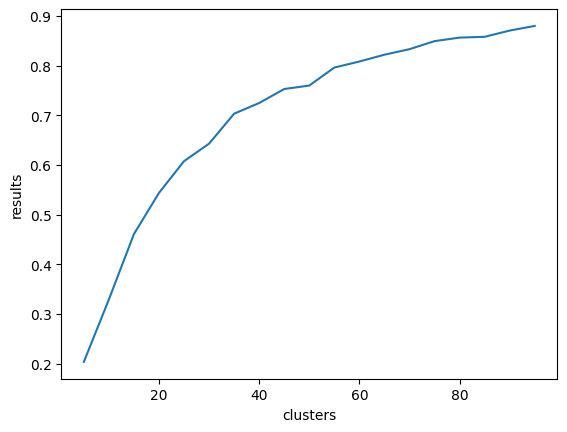

In [10]:
# Normalize matrix
matrix_norm = preprocessing.normalize(matrix)
matrix_sparse_norm = csr_array(matrix)

# Dictionary to store silhouette scores
silhouette_results_norm = {"clusters": [], "results": []}

# Get sample
num_rows_to_select = np.floor(0.01*len(matrix_norm)).astype("int")
num_rows = matrix_norm.shape[0]
random_indices = np.random.choice(num_rows, size=num_rows_to_select, replace=False)
random_matrix_sparse = matrix_sparse_norm[random_indices]
random_matrix = matrix_norm[random_indices]
# Generating scores
for n_cluster in np.arange(5,100,5):
    kmeans = KMeans(n_clusters=n_cluster, n_init="auto")
    y = kmeans.fit_predict(random_matrix)
    res = silhouette_score(random_matrix_sparse, y)
    silhouette_results_norm["clusters"].append(n_cluster)
    silhouette_results_norm["results"].append(res)

sns.lineplot(data=silhouette_results_norm, x="clusters", y="results")
plt.show()

In [12]:
# Normalize matrix
matrix_norm = preprocessing.normalize(matrix)
# Set final number of clusters
n_cluster = 35
# Create kmeans class and predict clusters for customers
kmeans = KMeans(n_clusters=n_cluster, n_init="auto")
index_name_cluster = kmeans.fit_predict(matrix_norm)
index_name_cluster = pd.DataFrame(zip(customer_baskets.keys(), index_name_cluster), columns=["customer_id","index_name_cluster"])
# Merge dataframes
customers = customers.merge(index_name_cluster, on="customer_id", how="left")
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,index_name_cluster
0,0,-1.0,-1.0,0,0,49.0,0,32.0
1,1,-1.0,-1.0,0,0,25.0,1,31.0
2,2,-1.0,-1.0,0,0,24.0,2,26.0
3,3,-1.0,-1.0,0,0,54.0,3,11.0
4,4,1.0,1.0,0,1,52.0,4,9.0


In [14]:
# one hot encoding 
articles = articles.set_index("article_id")
customers = customers.set_index("customer_id")

article_enc = OneHotEncoder(sparse_output=True)
articles = article_enc.fit_transform(articles)

customers_categorical = ["FN",'Active',"club_member_status", "fashion_news_frequency", "index_name_cluster"]
customers_cont = ["age"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), customers_categorical),
        ('cont', 'passthrough', customers_cont)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
customers = csr_matrix(preprocessor.fit_transform(customers))

# Training

In [16]:
# deep architecture
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")
train_dataloader, val_dataloader, test_customers = load_data_mf(transactions_negatives, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerCustomersCluster.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 55595/55595 [14:05<00:00, 65.74it/s]


Epoch [1/10] - Train Loss: 0.1316, Validation Loss: 0.1138


100%|██████████| 55595/55595 [14:06<00:00, 65.67it/s]


Epoch [2/10] - Train Loss: 0.1310, Validation Loss: 0.1132


100%|██████████| 55595/55595 [14:03<00:00, 65.95it/s]


Epoch [3/10] - Train Loss: 0.1324, Validation Loss: 0.1130


100%|██████████| 55595/55595 [13:45<00:00, 67.31it/s]


Epoch [4/10] - Train Loss: 0.1327, Validation Loss: 0.1129


100%|██████████| 55595/55595 [13:53<00:00, 66.73it/s]


Epoch [5/10] - Train Loss: 0.1348, Validation Loss: 0.1128


100%|██████████| 55595/55595 [13:51<00:00, 66.85it/s]


Epoch [6/10] - Train Loss: 0.1329, Validation Loss: 0.1128


100%|██████████| 55595/55595 [13:51<00:00, 66.89it/s]


Epoch [7/10] - Train Loss: 0.1330, Validation Loss: 0.1127


100%|██████████| 55595/55595 [13:56<00:00, 66.46it/s]


Epoch [8/10] - Train Loss: 0.1336, Validation Loss: 0.1127


100%|██████████| 55595/55595 [14:07<00:00, 65.56it/s]


Epoch [9/10] - Train Loss: 0.1333, Validation Loss: 0.1126


100%|██████████| 55595/55595 [13:54<00:00, 66.62it/s]


Epoch [10/10] - Train Loss: 0.1319, Validation Loss: 0.1126


# Evaluate Recomendations

In [19]:
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerCustomersCluster.pt")
matrix_full = matrix_representation(transactions, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:10<00:00, 127.62it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 229.96it/s]


Get recommendations...


100%|██████████| 137/137 [00:32<00:00,  4.26it/s]


Precision: 0.007071426299343997
Recall: 0.004230640155142991
